<a href="https://colab.research.google.com/github/zak-era12/Jovian-Assignments/blob/main/svhn_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Street View House Numbers Detection *

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1CyGLz-F5suBnoDLfkTyWFiYfCJN5osvj')

In [ ]:
!pip install jovian --upgrade --quiet

Our main goal is to detect and read house-number signs in Street View images. The entire end-toend system (described later) includes two main stages:

a detection stage that locates individual house numbers in a large image, and
a recognition stage that performs a search over possible character locations in the detected house number, classifying each candidate frame as one of ten digits (0 through 9)

**About the Dataset** <br>
The SVHN dataset was obtained from a large number of Street View images using a combination
of automated algorithms and the Amazon Mechanical Turk (AMT) framework, which was used to localize and transcribe the single digits. We downloaded a very large set of images from
urban areas in various countries. From these randomly selected images, the house-number patches
were extracted using a dedicated sliding window house-numbers detector using a low threshold
on the detector’s confidence score in order to get a varied, unbiased dataset of house-number signs.
These low precision detections1 were screened and transcribed by AMT workers. In total, the dataset
comprises over 600,000 labeled characters, and has been made available in two formats:


*   Full Numbers - the original, variable-resolution, color house-number images as they appeared in the image file. Each image includes a transcription of the detected digits as well
as character level bounding boxes. Figure 2 shows the large variation in character height
as measured by the height of the bounding box of the characters in the original Street View
images.
*   Cropped Digits - character level ground truth - in this MNIST-like format all digits have
been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes
are extended in the appropriate dimension to become square windows, so that resizing them
to 32-by-32 pixels does not introduce aspect ratio distortions.

The dataset is divided into three subsets-


*  SVHN train - 73,257 digits for training
* SVHN test - 26,032 digits for testing.
* SVHN extra (train) - 531,131 additional, somewhat less difficult samples, to use as extra
training data.
  

In [ ]:
project_name='svhn-project-final'

In [ ]:
# Importing necessary libraries
import os 
import torch 
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image 
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn 
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
import tarfile
%matplotlib inline
import tensorflow
import warnings
warnings.filterwarnings('ignore')
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.models import load_model
from sklearn.metrics import accuracy_score
import keras
import tempfile
import seaborn as sns
import scipy
from scipy.io import loadmat
import os
import numpy as np
import pandas as pd
## View sample data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.filters import correlate, convolve
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
import shutil

In [ ]:
#Download the dataset
train_data="http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
download_url(train_data,'.')
test_data="http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
download_url(test_data, '.')
# Read the Image Data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat


In [ ]:
# Save the Images in structure form
y_train = keras.utils.to_categorical(train_data['y'][:,0])[:,1:]
y_test = keras.utils.to_categorical(test_data['y'][:,0])[:,1:]

X_train = np.zeros((73257, 32, 32, 3))
for i in range(len(X_train)):
    X_train[i] = train_data['X'].T[i].T.astype('float32')/255

X_test = np.zeros((26032, 32, 32, 3))
for i in range(len(X_test)):
    X_test[i] = test_data['X'].T[i].T.astype('float32')/255

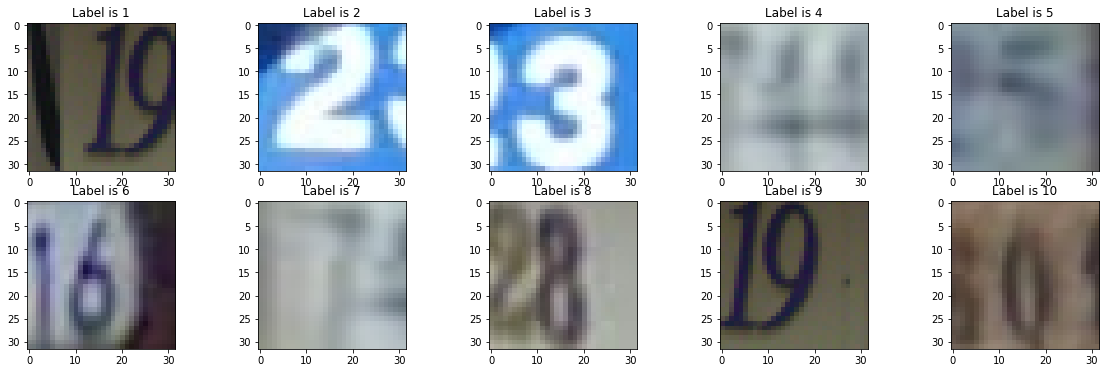

In [ ]:
## Visualize the Image with Label
y = train_data['y'][:,0]
y =np.where(y==1)[0][0],np.where(y==2)[0][0],np.where(y==3)[0][0],np.where(y==4)[0][0],np.where(y==5)[0][0],np.where(y==6)[0][0],np.where(y==7)[0][0],np.where(y==8)[0][0],np.where(y==9)[0][0],np.where(y==10)[0][0]

fig = plt.figure(figsize=(20,6))
axes = fig.subplots(nrows=2, ncols=5)

axes[0,0].set_title('Label is {}'.format(1))  ## Label 
axes[0,0].imshow(X_train[y[0]]) ## Image

axes[0,1].set_title('Label is {}'.format(2)) 
axes[0,1].imshow(X_train[y[1]])

axes[0,2].set_title('Label is {}'.format(3)) 
axes[0,2].imshow(X_train[y[2]])

axes[0,3].set_title('Label is {}'.format(4)) 
axes[0,3].imshow(X_train[y[3]])

axes[0,4].set_title('Label is {}'.format(5)) 
axes[0,4].imshow(X_train[y[4]])

axes[1,0].set_title('Label is {}'.format(6)) 
axes[1,0].imshow(X_train[y[5]])

axes[1,1].set_title('Label is {}'.format(7)) 
axes[1,1].imshow(X_train[y[6]])

axes[1,2].set_title('Label is {}'.format(8)) 
axes[1,2].imshow(X_train[y[7]])

axes[1,3].set_title('Label is {}'.format(9)) 
axes[1,3].imshow(X_train[y[8]])

axes[1,4].set_title('Label is {}'.format(10)) 
axes[1,4].imshow(X_train[y[9]])
plt.show()

In [ ]:
# Number of Class
np.unique(train_data['y'][:,0])
# There are 10 unique classes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [ ]:
# We will use 3 filters,1 drop out with 
# Max pooling of 2,2 pixel i.e. taking the max from 2 col & 2 rows
# 1 layers of weights i.e. Dense Layer

num_classes = 10      # Number of classes to model
cnn = Sequential()    
cnn.add(Conv2D(32, kernel_size=(4, 4),activation='relu',input_shape=(32, 32, 3))) ## First convolutional layer with (4,4) filter 
cnn.add(Conv2D(32, kernel_size = (4,4), activation = 'relu'))
cnn.add(Conv2D(32, kernel_size = (4,4), activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dense(num_classes, activation='softmax'))
    
cnn.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

In [ ]:
## Train the data using 20 epochs and batch size 128
history_cnn = cnn.fit(X_train, y_train,
                          batch_size=128, epochs=20, verbose=1, validation_split=.1)

scores = cnn.evaluate(X_test, y_test, batch_size = 128, verbose = 0)
print("%s: %.2f%%" % (cnn.metrics_names[1], scores[1]*100))

Epoch 1/20
516/516 [==============================] - 274s 529ms/step - loss: 1.4673 - accuracy: 0.4993 - val_loss: 0.4848 - val_accuracy: 0.8649
Epoch 2/20
516/516 [==============================] - 273s 529ms/step - loss: 0.4432 - accuracy: 0.8709 - val_loss: 0.4010 - val_accuracy: 0.8886
Epoch 3/20
516/516 [==============================] - 273s 529ms/step - loss: 0.3499 - accuracy: 0.8991 - val_loss: 0.3727 - val_accuracy: 0.8909
Epoch 4/20
516/516 [==============================] - 273s 528ms/step - loss: 0.3033 - accuracy: 0.9101 - val_loss: 0.3458 - val_accuracy: 0.9014
Epoch 5/20
516/516 [==============================] - 273s 528ms/step - loss: 0.2560 - accuracy: 0.9264 - val_loss: 0.3256 - val_accuracy: 0.9088
Epoch 6/20
516/516 [==============================] - 273s 529ms/step - loss: 0.2149 - accuracy: 0.9387 - val_loss: 0.3326 - val_accuracy: 0.9031
Epoch 7/20
516/516 [==============================] - 272s 528ms/step - loss: 0.1847 - accuracy: 0.9447 - val_loss: 0.3238 -

In [ ]:
# Predict the classes given to model, we do not want probabilities for each class.
class_prediction =cnn.predict_classes(X_test,batch_size=128,verbose=True)

151/204 [=====================>........] - ETA: 4s

In [ ]:
# Add the 1 to the classes because it classes was given from 0 to 9 i.e. 10 classes but we want from 1 to 10. Its python functionality that it start from 0.
Predicted_class_label=class_prediction+1

In [ ]:
# Print the Accuracy
y_actual = test_data['y'][:,0]
print('Predicted Accuracy on Test is {}'.format(accuracy_score(y_actual,Predicted_class_label,normalize=True)*100))

Predicted Accuracy on Test is 88.07237246465888


In [ ]:
# Visualize the Image with Actual Label and Predicted Label using imshow function from Matplotlib
y = test_data['y'][:,0]

fig = plt.figure(figsize=(20,6))
axes = fig.subplots(nrows=2, ncols=5)

axes[0,0].set_title('Actual {} & Predicted {}'.format(y[0],Predicted_class_label[0]))  ## Label 
axes[0,0].imshow(X_test[0]) ## Image

axes[0,1].set_title('Actual {} & Predicted {}'.format(y[1],Predicted_class_label[1]))
axes[0,1].imshow(X_test[1])

axes[0,2].set_title('Actual {} & Predicted {}'.format(y[2],Predicted_class_label[2]))
axes[0,2].imshow(X_test[2])

axes[0,3].set_title('Actual {} & Predicted {}'.format(y[3],Predicted_class_label[3]))
axes[0,3].imshow(X_test[3])

axes[0,4].set_title('Actual {} & Predicted {}'.format(y[4],Predicted_class_label[4]))
axes[0,4].imshow(X_test[4])

axes[1,0].set_title('Actual {} & Predicted {}'.format(y[5],Predicted_class_label[5]))
axes[1,0].imshow(X_test[5])

axes[1,1].set_title('Actual {} & Predicted {}'.format(y[6],Predicted_class_label[6]))
axes[1,1].imshow(X_test[6])

axes[1,2].set_title('Actual {} & Predicted {}'.format(y[7],Predicted_class_label[7]))
axes[1,2].imshow(X_test[7])

axes[1,3].set_title('Actual {} & Predicted {}'.format(y[8],Predicted_class_label[8]))
axes[1,3].imshow(X_test[8])

axes[1,4].set_title('Actual {} & Predicted {}'.format(y[9],Predicted_class_label[9]))
axes[1,4].imshow(X_test[9])
plt.show()


In [ ]:
# Visualize the confusion matrix so that we can identify which class was misclassified in which classes minimum or maximum times

plt.figure(figsize = (12,6))
sns.heatmap(pd.crosstab(y,Predicted_class_label,rownames=['Actual'],colnames=['Predicted']), annot=True,  fmt="d",cmap="YlGnBu",robust =True)
plt.show()

## As you see 7 number misclassified in 1, 8 in 6, 3 in 9 &5 etc.

In [ ]:
#Using Batch Normalization
# We will use 3 filters,3 drop out with 
# Batch Normalization to normalize the pixels in each filter so that model each of itself more independently of other layers 
# Max pooling of 2,2 pixel i.e. taking the max from 2 col & 2 rows
# 3 layers of weights i.e. Dense Layer

num_classes = 10      # Number of classes to model
cnn = Sequential()    
cnn.add(Conv2D(32, kernel_size=(4, 4),activation='relu',input_shape=(32, 32, 3))) ## First convolutional layer with (4,4) filter 
cnn.add(Dropout(0.2))         ## Dropout of 0.2
cnn.add(BatchNormalization())
cnn.add(Conv2D(32, kernel_size = (4,4), activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(32, kernel_size = (4,4), activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization(axis = 3))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dense(num_classes, activation='softmax'))
    
cnn.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

In [ ]:
# Train the data using 20 epochs and batch size 128
history_cnn = cnn.fit(X_train, y_train,
                          batch_size=128, epochs=20, verbose=1, validation_split=.1)

scores = cnn.evaluate(X_test, y_test, batch_size = 128, verbose = 0)
print("%s: %.2f%%" % (cnn.metrics_names[1], scores[1]*100))

Epoch 1/20
516/516 [==============================] - 331s 640ms/step - loss: 1.4257 - accuracy: 0.5263 - val_loss: 1.1825 - val_accuracy: 0.6451
Epoch 2/20
516/516 [==============================] - 329s 638ms/step - loss: 0.4045 - accuracy: 0.8774 - val_loss: 0.4130 - val_accuracy: 0.8754
Epoch 3/20
516/516 [==============================] - 329s 638ms/step - loss: 0.2971 - accuracy: 0.9089 - val_loss: 0.4174 - val_accuracy: 0.8733
Epoch 4/20
516/516 [==============================] - 329s 637ms/step - loss: 0.2465 - accuracy: 0.9249 - val_loss: 0.3892 - val_accuracy: 0.8803
Epoch 5/20
516/516 [==============================] - 329s 637ms/step - loss: 0.2034 - accuracy: 0.9378 - val_loss: 0.3710 - val_accuracy: 0.8901
Epoch 6/20
516/516 [==============================] - 330s 639ms/step - loss: 0.1680 - accuracy: 0.9500 - val_loss: 0.4532 - val_accuracy: 0.8640
Epoch 7/20
516/516 [==============================] - 327s 634ms/step - loss: 0.1398 - accuracy: 0.9566 - val_loss: 0.3629 -

In [ ]:
jovian.reset()

jovian.log_hyperparams({
    'num_epochs': 20,
    'batch_size': 128,
})

[jovian] Hyperparams logged.


In [ ]:
# Save the batch model so that we can reuse this instead of running train again.
cnn.save('svhn_model_normal.h5')

In [ ]:
# Predict the classes given to model, we do not want probabilities for each class.
class_prediction =cnn.predict_classes(X_test,batch_size=128,verbose=True)

In [ ]:
# Add the 1 to the classes because it classes was given from 0 to 9 i.e. 10 classes but we want from 1 to 10. Its python functionality that it start from 0.
Predicted_class_label=class_prediction+1

In [ ]:
# Print the Accuracy
y_actual = test_data['y'][:,0]
print('Predicted Accuracy on Test is {}'.format(accuracy_score(y_actual,Predicted_class_label,normalize=True)*100))

Predicted Accuracy on Test is 88.88291333743086


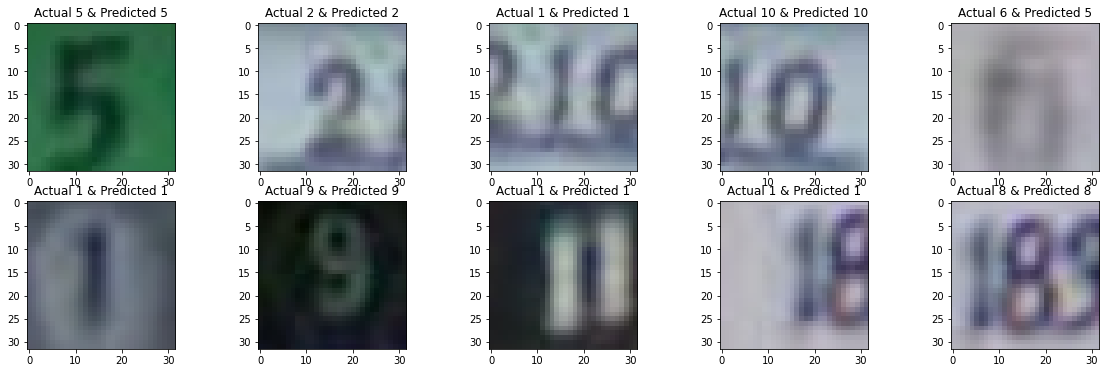

In [ ]:
# Visualize the Image with Actual Label and Predicted Label using imshow function from Matplotlib
y = test_data['y'][:,0]

fig = plt.figure(figsize=(20,6))
axes = fig.subplots(nrows=2, ncols=5)

axes[0,0].set_title('Actual {} & Predicted {}'.format(y[0],Predicted_class_label[0]))  ## Label 
axes[0,0].imshow(X_test[0]) ## Image

axes[0,1].set_title('Actual {} & Predicted {}'.format(y[1],Predicted_class_label[1]))
axes[0,1].imshow(X_test[1])

axes[0,2].set_title('Actual {} & Predicted {}'.format(y[2],Predicted_class_label[2]))
axes[0,2].imshow(X_test[2])

axes[0,3].set_title('Actual {} & Predicted {}'.format(y[3],Predicted_class_label[3]))
axes[0,3].imshow(X_test[3])

axes[0,4].set_title('Actual {} & Predicted {}'.format(y[4],Predicted_class_label[4]))
axes[0,4].imshow(X_test[4])

axes[1,0].set_title('Actual {} & Predicted {}'.format(y[5],Predicted_class_label[5]))
axes[1,0].imshow(X_test[5])

axes[1,1].set_title('Actual {} & Predicted {}'.format(y[6],Predicted_class_label[6]))
axes[1,1].imshow(X_test[6])

axes[1,2].set_title('Actual {} & Predicted {}'.format(y[7],Predicted_class_label[7]))
axes[1,2].imshow(X_test[7])

axes[1,3].set_title('Actual {} & Predicted {}'.format(y[8],Predicted_class_label[8]))
axes[1,3].imshow(X_test[8])

axes[1,4].set_title('Actual {} & Predicted {}'.format(y[9],Predicted_class_label[9]))
axes[1,4].imshow(X_test[9])
plt.show()


In [ ]:
# Visualize the confusion matrix so that we can identify which class was misclassified in which classes minimum or maximum times

plt.figure(figsize = (12,6))
sns.heatmap(pd.crosstab(y,Predicted_class_label,rownames=['Actual'],colnames=['Predicted']), annot=True,  fmt="d",cmap="YlGnBu",robust =True)
plt.show()

## As you see 7 number misclassified in 1, 8 in 6, 3 in 9 &5 etc.

In [ ]:
jovian.commit(project=project_name, environment=None)